# **Nick Newman - Homework 2**

Problem 1: Coding a single layer neural network without using a Machine Learning or Deep Learning framework

In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt

# Reading in the files
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
X_train = read_idx('train-images-idx3-ubyte')
y_train = read_idx('train-labels-idx1-ubyte')
X_test = read_idx('t10k-images-idx3-ubyte')
y_test = read_idx('t10k-labels-idx1-ubyte')

0


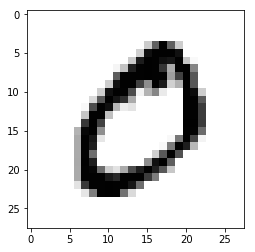

1


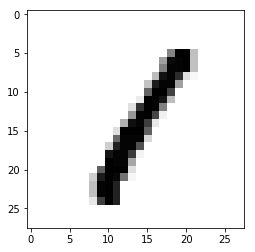

2


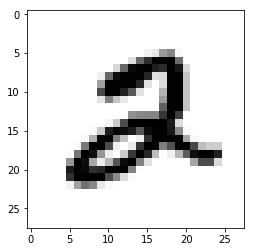

3


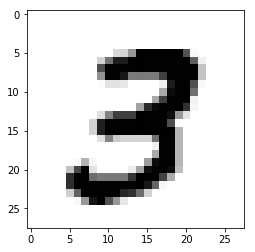

4


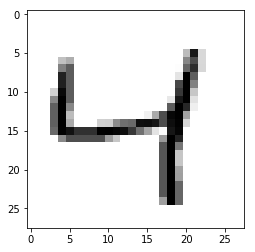

5


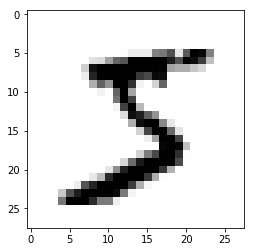

6


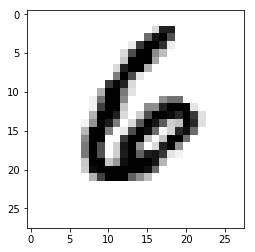

7


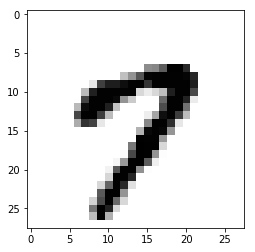

8


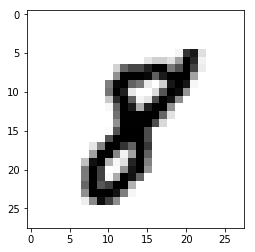

9


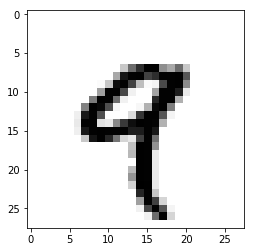

In [2]:
# Showing graphs with samples of the handwritten numbers
for i in np.unique(y_train):
    plt.imshow(X_train[y_train==i][0], cmap="binary")
    print(i)
    plt.show()


In [3]:
class MLP:
    """ Defining a One-Hidden Layer Neural Network Model (Multi-Layer Perceptron)
        for classification wit Mini-Batch Gradient Descent
    
    The parameters are:
        n_iter: number of iterations over the dataset
        eta: learning rate/step value
        n_hidden: number of hidden neurons in the network
        hidden_act: activation function that is used on the hidden layer
        encode: if the target values are not in binary form, then this 
        will one hot encode them
        batch_size: number of samples used in each batch
        
    """
    
    def __init__(self, n_iter=1000, eta=0.05, n_hidden=10, hidden_act = 'sigmoid',
                 encode=True, batch_size=1):
        self.n_iter = n_iter
        self.eta = eta
        self.encode=encode
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.hidden_act = hidden_act
            
    def hidden_layer(self, z):
        # defining which activation function gets used in the hidden layer
        # adding an upper limit to the relu values to prevent the gradient from 
        # exploding
        if self.hidden_act=='relu':
            return np.clip(z, 0, 250)
        else:
            return 1/(1+ np.exp(-z))

    def softmax(self, z):
        # This is the softmax function of z_out
        # used to get the predicted class for a multi-class problem
        # scaling the softmax results to prevent values from converging to nan
        z = z- np.max(z)
        return np.exp(z)/np.sum(np.exp(z), axis=1).reshape(-1,1)
    
    def onehot(self, data):
        """ This takes in target values and returns them coded in binary for each
            distinct class. The index values don't necessarily correspond to the
            original target values as the values are mapped into a distinct range.
        """
        n_classes = np.unique(data)
        onehot_array = np.zeros((data.shape[0], np.max(data)+1))
        onehot_array[np.arange(data.shape[0]), data] = 1
        if n_classes.shape[0] > 2:
            return onehot_array[:,n_classes]     
        # return only one column if there are only two target variable to avoid
        # redundancy. This reflects the first instance (ordinal) in the data.
        else:
            return onehot_array[:,n_classes[0]]
        
    
    def forward_prop(self, X):
        # forward propogation through the neural network
        
        # [num in X, num of features] dot [num of features, n hidden units] + [hidden bias]
        # -> [num in X, n hidden units] 
        Z_h = np.dot(X, self.Wh) + self.bias_h
        
        # Hidden layer activation function
        # [num in X, n hidden units] 
        A_h = self.hidden_layer(Z_h)
        
        # Z output of hidden layer
        # [num in X,n hidden units] dot [num hidden units, n classes]
        # -> [num in X, n classes]
        Z_out = np.dot(A_h, self.Wout) + self.bias_out
        
        # output layer activation function
        # [num in X, n classes]
        A_out = self.softmax(Z_out)
        return Z_h, A_h, Z_out, A_out


    def backprop(self, Z_h, A_h, Z_out, A_out, X_train, y_train):    
        # backpropagating through the network to determine the gradients
        
        # [num in X, n classes]
        output_error = A_out - y_train
        
        # [n hidden units, num in X] dot [num in X, n classes]
        # -> [n hidden units, n classes]
        DJ_DWout = np.dot(A_h.T, output_error)
        
        # [num in X, n hidden units] 
        # The derivatives of the activation functions are different
        if self.hidden_act == 'relu':
            hidden_deriv = A_h
            hidden_deriv[hidden_deriv > 0] = 1
            hidden_deriv[hidden_deriv <= 0] = 0
        else:
            hidden_deriv = A_h * (1-A_h)
        
        # [num in X, n classes] dot [n classes, num hidden units]
        # * [num in X, n hidden units] -> [num in X, n hidden units]
        DJ_DWhid = np.dot(output_error, self.Wout.T) * hidden_deriv
        
        # gradient of layer 1 W and layer 1 bias
        # [n hidden units, num in X] dot [num in X, n classes]
        # -> [n hidden units, n classes]
        grad_Whid = np.dot(X_train.T, DJ_DWhid)
        grad_Bhid = np.sum(DJ_DWhid, axis=0)
        
        # gradient of layer 2 W and layer 2 bias
        # [num of features, num in X] dot [num in X, n hidden units]
        # -> [num of features, n hidden units]
        grad_Wout = DJ_DWout
        grad_Bout = np.sum(output_error, axis=0)
        
        # updating the gradients
        self.Wh -= grad_Whid * self.eta
        self.bias_h -= grad_Bhid * self.eta
        
        self.Wout -= grad_Wout * self.eta
        self.bias_out -= grad_Bout * self.eta
        
        
    def fit(self, X_train, y_train, X_valid, y_valid):
        # fit the training data
        if self.encode:
            y_train_oh = self.onehot(y_train)
        n_classes = y_train_oh.shape[1]
        n_features = X_train.shape[1]
        
        # initialize the values of the weights to random normal values
        self.Wh = np.random.randn(n_features, self.n_hidden)
        self.Wout = np.random.randn(self.n_hidden, n_classes)
        
        # initialize the values of the biases to zero
        self.bias_h = np.zeros((1,self.n_hidden))
        self.bias_out = np.zeros((1,n_classes))
        
        # m = number of samples
        m = y_train.shape[0]

        # dictionary to keep track of the values as the network goes through
        # the iterations
        self.metrics = {'cost': [],'train_accuracy': [], 'valid_accuracy':[]}

        for i in range(self.n_iter):
            
            shuffled_values = np.random.permutation(m)
            X_shuffled = X_train[shuffled_values]
            y_shuffled = y_train_oh[shuffled_values]
            for batch in range(0, m, self.batch_size):
                x_batch = X_shuffled[batch:batch+self.batch_size]
                y_batch = y_shuffled[batch:batch+self.batch_size]
                
                # forward propagation
                Z_h, A_h, Z_out, A_out = self.forward_prop(x_batch)
                
                # backpropagation
                self.backprop(Z_h, A_h, Z_out, A_out, x_batch, y_batch)
            
            # After each iteration, do an evaluation
            # Evaluating on the training set
            Z_h, A_h, Z_out, A_out = self.forward_prop(X_train)
            cost = self.cost_function(A_out, y_train_oh)
            train_predictions = self.predict(A_out)
            
            # Evaluating on the validation set
            Z_h, A_h, Z_out, A_out = self.forward_prop(X_valid)
            valid_predictions = self.predict(A_out)

            train_accuracy = np.sum(train_predictions == y_train).astype(np.float)/train_predictions.shape[0]
            valid_accuracy = np.sum(valid_predictions == y_valid).astype(np.float)/valid_predictions.shape[0]
            
            if not (i+1)%10:
                print("Iteration: {}\t Train Acc: {:.3f}\t Validation Acc: {:.3f}".format(i+1, train_accuracy, valid_accuracy))
            
            self.metrics['cost'].append(cost)
            self.metrics['train_accuracy'].append(train_accuracy)
            self.metrics['valid_accuracy'].append(valid_accuracy)
            
        return self
            
    def cost_function(self, A_out, y):
       return np.average(-y*np.log(A_out) - ((1-y)*np.log(1-A_out)))
        
   
    def predict(self, output):
        # return the value with the highest percentage
        return np.argmax(output, axis=1)
        

Problem 2: Coding a single layer neural network without using a Machine Learning or Deep Learning framework and using L2 Regularization

In [4]:
class MLP_l2:
    """ Defining a One-Hidden Layer Neural Network Model (Multi-Layer Perceptron)
        for classification with l2 regularization and Mini-Batch Gradient Descent
    
    The parameters are: 
        l2: l2 regularization rate
        n_iter: number of iterations over the dataset
        eta: learning rate/step value
        n_hidden: number of hidden neurons in the network
        hidden_act: activation function that is used on the hidden layer
        encode: if the target values are not in binary form, then this 
        will one hot encode them
        batch_size: number of samples used in each batch
    """

    
    def __init__(self, l2=0.0, n_iter=1000, eta=0.05, n_hidden=10, hidden_act = 'sigmoid',
                 encode=True, batch_size=1):
        self.l2 = l2
        self.n_iter = n_iter
        self.eta = eta
        self.encode=encode
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.hidden_act = hidden_act
            
    def hidden_layer(self, z):
        # defining which activation function gets used in the hidden layer
        # adding an upper limit to the relu values to prevent the gradient from 
        # exploding
        if self.hidden_act=='relu':
            return np.clip(z, 0, 250)
        else:
            return 1/(1+ np.exp(-z))

    
    def softmax(self, z):
        # This is the softmax function of z_out
        # used to get the predicted class for a multi-class problem
        # scaling the softmax results to prevent values from converging to nan
        z = z- np.max(z)
        return np.exp(z)/np.sum(np.exp(z), axis=1).reshape(-1,1)
    
    def onehot(self, data):
        """ This takes in target values and returns them coded in binary for each
            distinct class. The index values don't necessarily correspond to the
            original target values as the values are mapped into a distinct range.
        """
        n_classes = np.unique(data)
        onehot_array = np.zeros((data.shape[0], np.max(data)+1))
        onehot_array[np.arange(data.shape[0]), data] = 1
        if n_classes.shape[0] > 2:
            return onehot_array[:,n_classes]     
        # return only one column if there are only two target variable to avoid
        # redundancy. This reflects the first instance (ordinal) in the data.
        else:
            return onehot_array[:,n_classes[0]]
        
    
    def forward_prop(self, X):
        # forward propogation through the neural network
        
        # [num in X, num of features] dot [num of features, n hidden units] + [hidden bias]
        # -> [num in X, n hidden units] 
        Z_h = np.dot(X, self.Wh) + self.bias_h
        
        # Hidden layer activation function
        # [num in X, n hidden units] 
        A_h = self.hidden_layer(Z_h)
        
        # Z output of hidden layer
        # [num in X,n hidden units] dot [num hidden units, n classes]
        # -> [num in X, n classes]
        Z_out = np.dot(A_h, self.Wout) + self.bias_out
        
        # output layer activation function
        # [num in X, n classes]
        A_out = self.softmax(Z_out)
        return Z_h, A_h, Z_out, A_out


    def backprop(self, Z_h, A_h, Z_out, A_out, X_train, y_train):       
        # [num in X, n classes]
        output_error = A_out - y_train
        
        # [n hidden units, num in X] dot [num in X, n classes]
        # -> [n hidden units, n classes]
        DJ_DWout = np.dot(A_h.T, output_error)
        
        # [num in X, n hidden units] 
        # The derivatives of the activation functions are different
        if self.hidden_act == 'relu':
            hidden_deriv = A_h
            hidden_deriv[hidden_deriv > 0] = 1
            hidden_deriv[hidden_deriv <= 0] = 0
        else:
            hidden_deriv = A_h * (1-A_h)
            
        # [num in X, n classes] dot [n classes, num hidden units]
        # * [num in X, n hidden units] -> [num in X, n hidden units]
        DJ_DWhid = np.dot(output_error, self.Wout.T) * hidden_deriv
        
        # gradient of layer 1 W and layer 1 bias
        # [n hidden units, num in X] dot [num in X, n classes]
        # -> [n hidden units, n classes]
        grad_Whid = np.dot(X_train.T, DJ_DWhid)
        grad_Bhid = np.sum(DJ_DWhid, axis=0)
        
        # gradient of layer 2 W and layer 2 bias
        # [num of features, num in X] dot [num in X, n hidden units]
        # -> [num of features, n hidden units]
        grad_Wout = DJ_DWout
        grad_Bout = np.sum(output_error, axis=0)
        
        
        ## Regularization 
        # we don't add regularization to the bias terms
        l2_Whid = self.Wh * self.l2        
        l2_Wout = self.Wout * self.l2
        
        self.Wh -= (grad_Whid + l2_Whid) * self.eta
        self.bias_h -= grad_Bhid * self.eta
        
        self.Wout -= (grad_Wout * self.eta) + l2_Wout
        self.bias_out -= grad_Bout * self.eta
    
        
        
    def fit(self, X_train, y_train, X_valid, y_valid):
        # fit the training data
        if self.encode:
            y_train_oh = self.onehot(y_train)
        n_classes = y_train_oh.shape[1]
        n_features = X_train.shape[1]
        
        # initialize the values of the weights to random normal values
        self.Wh = np.random.randn(n_features, self.n_hidden)
        self.Wout = np.random.randn(self.n_hidden, n_classes)
        
        # initialize the values of the biases to zero
        self.bias_h = np.zeros((1,self.n_hidden))
        self.bias_out = np.zeros((1,n_classes))
        
        # m = number of samples
        m = y_train.shape[0]

        # dictionary to keep track of the values as the network goes through
        # the iterations
        self.metrics = {'cost': [],'train_accuracy': [], 'valid_accuracy':[]}

        for i in range(self.n_iter):
            
            shuffled_values = np.random.permutation(m)
            X_shuffled = X_train[shuffled_values]
            y_shuffled = y_train_oh[shuffled_values]
            for batch in range(0, m, self.batch_size):
                x_batch = X_shuffled[batch:batch+self.batch_size]
                y_batch = y_shuffled[batch:batch+self.batch_size]
                
                # forward propagation
                Z_h, A_h, Z_out, A_out = self.forward_prop(x_batch)
                
                # backpropagation
                self.backprop(Z_h, A_h, Z_out, A_out, x_batch, y_batch)
            
            # After each iteration, do an evaluation
            # Evaluating on the training set
            Z_h, A_h, Z_out, A_out = self.forward_prop(X_train)
            cost = self.cost_function(A_out, y_train_oh)
            train_predictions = self.predict(A_out)
            
            # Evaluating on the validation set
            Z_h, A_h, Z_out, A_out = self.forward_prop(X_valid)
            valid_predictions = self.predict(A_out)

            train_accuracy = np.sum(train_predictions == y_train).astype(np.float)/train_predictions.shape[0]
            valid_accuracy = np.sum(valid_predictions == y_valid).astype(np.float)/valid_predictions.shape[0]
            
            if not (i+1)%10:
                print("Iteration: {}\t Train Acc: {:.3f}\t Validation Acc: {:.3f}".format(i+1, train_accuracy, valid_accuracy))
            
            self.metrics['cost'].append(cost)
            self.metrics['train_accuracy'].append(train_accuracy)
            self.metrics['valid_accuracy'].append(valid_accuracy)
            
        return self
            
    def cost_function(self, A_out, y):
        m = y.shape[0]
        l2_cost = (self.l2/(2*m))*(np.sum(self.Wh**2)+np.sum(self.Wout**2))
        return np.average(-y*np.log(A_out) - ((1-y)*np.log(1-A_out))) + l2_cost
   
    def predict(self, output):
        # return the value with the highest percentage
        return np.argmax(output, axis=1)

Running the code for Problems 1 and 2

In [5]:
## Scaling the values so that the model can more accurately adjust the weights
X_train = X_train.astype(np.float)/255.
X_test = X_test.astype(np.float)/255.

In [6]:
## Reshaping the arrays so that they can be input accordingly
X_train = X_train.reshape(-1,784)
X_test = X_test.reshape(-1,784)

**Running Models without L2 Regularization (Problem 1)**

Sigmoid hidden activation, 50 hidden layers, 0.001 learning rate, 500 batch size

In [7]:
# Running a NN without L2 Regularization
model = MLP(n_iter=100,n_hidden=50, batch_size=500, eta=0.001)

model.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

Iteration: 10	 Train Acc: 0.869	 Validation Acc: 0.882
Iteration: 20	 Train Acc: 0.898	 Validation Acc: 0.906
Iteration: 30	 Train Acc: 0.912	 Validation Acc: 0.917
Iteration: 40	 Train Acc: 0.922	 Validation Acc: 0.923
Iteration: 50	 Train Acc: 0.928	 Validation Acc: 0.926
Iteration: 60	 Train Acc: 0.933	 Validation Acc: 0.930
Iteration: 70	 Train Acc: 0.937	 Validation Acc: 0.933
Iteration: 80	 Train Acc: 0.941	 Validation Acc: 0.936
Iteration: 90	 Train Acc: 0.945	 Validation Acc: 0.938
Iteration: 100	 Train Acc: 0.948	 Validation Acc: 0.939


Having a ReLU activation function on the hidden layer seems to generate a higher accuracy

Relu hidden activation, 50 hidden layers, 0.001 learning rate, 500 batch size

In [8]:
model = MLP(n_iter=100,n_hidden=50, batch_size=500, eta=0.001, hidden_act='relu')

model.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

Iteration: 10	 Train Acc: 0.869	 Validation Acc: 0.872
Iteration: 20	 Train Acc: 0.905	 Validation Acc: 0.899
Iteration: 30	 Train Acc: 0.915	 Validation Acc: 0.909
Iteration: 40	 Train Acc: 0.933	 Validation Acc: 0.926
Iteration: 50	 Train Acc: 0.936	 Validation Acc: 0.932
Iteration: 60	 Train Acc: 0.937	 Validation Acc: 0.933
Iteration: 70	 Train Acc: 0.943	 Validation Acc: 0.938


C:\Users\nickn\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: RuntimeWarning: divide by zero encountered in log
C:\Users\nickn\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: RuntimeWarning: invalid value encountered in multiply


Iteration: 80	 Train Acc: 0.948	 Validation Acc: 0.939
Iteration: 90	 Train Acc: 0.952	 Validation Acc: 0.945
Iteration: 100	 Train Acc: 0.955	 Validation Acc: 0.945


Relu hidden activation, 50 hidden layers, 0.0001 learning rate, 500 batch size

In [10]:
model = MLP(n_iter=100,n_hidden=50, batch_size=500, eta=0.0001, hidden_act='relu')

model.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

C:\Users\nickn\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: RuntimeWarning: divide by zero encountered in log
C:\Users\nickn\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: RuntimeWarning: invalid value encountered in multiply


Iteration: 10	 Train Acc: 0.775	 Validation Acc: 0.790
Iteration: 20	 Train Acc: 0.809	 Validation Acc: 0.823
Iteration: 30	 Train Acc: 0.831	 Validation Acc: 0.848
Iteration: 40	 Train Acc: 0.846	 Validation Acc: 0.859
Iteration: 50	 Train Acc: 0.860	 Validation Acc: 0.871
Iteration: 60	 Train Acc: 0.858	 Validation Acc: 0.869
Iteration: 70	 Train Acc: 0.877	 Validation Acc: 0.887
Iteration: 80	 Train Acc: 0.875	 Validation Acc: 0.885
Iteration: 90	 Train Acc: 0.890	 Validation Acc: 0.899
Iteration: 100	 Train Acc: 0.892	 Validation Acc: 0.900


Relu hidden activation, 20 hidden layers, 0.001 learning rate, 500 batch size

In [13]:
model = MLP(n_iter=100,n_hidden=20, batch_size=500, eta=0.001, hidden_act='relu')

model.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

C:\Users\nickn\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: RuntimeWarning: invalid value encountered in multiply


Iteration: 10	 Train Acc: 0.805	 Validation Acc: 0.817
Iteration: 20	 Train Acc: 0.880	 Validation Acc: 0.888
Iteration: 30	 Train Acc: 0.900	 Validation Acc: 0.906


C:\Users\nickn\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: RuntimeWarning: divide by zero encountered in log


Iteration: 40	 Train Acc: 0.910	 Validation Acc: 0.913
Iteration: 50	 Train Acc: 0.916	 Validation Acc: 0.919
Iteration: 60	 Train Acc: 0.922	 Validation Acc: 0.923
Iteration: 70	 Train Acc: 0.923	 Validation Acc: 0.924
Iteration: 80	 Train Acc: 0.929	 Validation Acc: 0.929
Iteration: 90	 Train Acc: 0.931	 Validation Acc: 0.933
Iteration: 100	 Train Acc: 0.932	 Validation Acc: 0.932


**Running Models with L2 Regularization (Problem 2)**

Sigmoid hidden activation, 50 hidden layers, 0.001 learning rate, 500 batch size, 0.1 l2

In [15]:
model = MLP_l2(n_iter=100,n_hidden=50, batch_size=500, eta=0.001, l2=0.1)

model.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])  
   

Iteration: 10	 Train Acc: 0.704	 Validation Acc: 0.727
Iteration: 20	 Train Acc: 0.760	 Validation Acc: 0.779
Iteration: 30	 Train Acc: 0.748	 Validation Acc: 0.768
Iteration: 40	 Train Acc: 0.804	 Validation Acc: 0.823
Iteration: 50	 Train Acc: 0.830	 Validation Acc: 0.847
Iteration: 60	 Train Acc: 0.835	 Validation Acc: 0.852
Iteration: 70	 Train Acc: 0.849	 Validation Acc: 0.864
Iteration: 80	 Train Acc: 0.851	 Validation Acc: 0.866
Iteration: 90	 Train Acc: 0.866	 Validation Acc: 0.880
Iteration: 100	 Train Acc: 0.872	 Validation Acc: 0.883


Sigmoid hidden activation, 50 hidden layers, 0.001 learning rate, 500 batch size, 0.5 l2

Higher l2 regularization rates make it harder for the network to learn the data

In [16]:
model = MLP_l2(n_iter=100,n_hidden=50, batch_size=500, eta=0.001, l2=0.5)

model.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

Iteration: 10	 Train Acc: 0.530	 Validation Acc: 0.554
Iteration: 20	 Train Acc: 0.498	 Validation Acc: 0.515
Iteration: 30	 Train Acc: 0.502	 Validation Acc: 0.508
Iteration: 40	 Train Acc: 0.497	 Validation Acc: 0.503
Iteration: 50	 Train Acc: 0.569	 Validation Acc: 0.574
Iteration: 60	 Train Acc: 0.591	 Validation Acc: 0.605
Iteration: 70	 Train Acc: 0.490	 Validation Acc: 0.492
Iteration: 80	 Train Acc: 0.597	 Validation Acc: 0.613
Iteration: 90	 Train Acc: 0.648	 Validation Acc: 0.666
Iteration: 100	 Train Acc: 0.516	 Validation Acc: 0.523


L2 Regularized Neural Networks take longer to converge, but the regularization helps to prevent overfitting on the training set. The key is to toggle the regularization rate so that it isn't too high as to prevent the network from learning.